In [1]:
"""
🩺 Breast Cancer Classification – Model Training and Evaluation

This script is for binary classification of breast cancer medical images:
- Class 1: Malignant
- Class 0: Benign or Normal

It uses PyTorch with custom data loaders, pretrained Swin Transformer models from Hugging Face

Steps:
- Load and preprocess colorized CT/X-ray images
- Build and train a Swin Transformer using Hugging Face Transformers
"""

# === Imports ===
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# === Config ===
IMG_SIZE = 224
BATCH_SIZE = 32

# === Data Paths ===
train_dir = "/kaggle/input/breast-cancer-medical-imaging-colorized-dataset/Breast Cancer/dataset/train"
val_dir = "/kaggle/input/breast-cancer-medical-imaging-colorized-dataset/Breast Cancer/dataset/validation"
test_dir = '/kaggle/input/breast-cancer-medical-imaging-colorized-dataset/Breast Cancer/dataset/test'

In [2]:
# List the class folders (aneurysm, cancer, tumor)
main_classes = os.listdir(train_dir)

# Show class names found
print(main_classes)

['0', '1']


In [3]:
# Collect image info: class label and file path
data = []

for cls in main_classes:
    class_folder = os.path.join(train_dir, cls)
    if os.path.isdir(class_folder):
        # Get all images in the class folder
        image_files = glob(os.path.join(class_folder, '*.*'))  # jpg, png, etc.

        # Store class name and path for each image
        for img_path in image_files:
            data.append({
                'class': cls,
                'image_path': img_path
            })

# Convert to DataFrame for easy viewing or manipulation
df = pd.DataFrame(data)

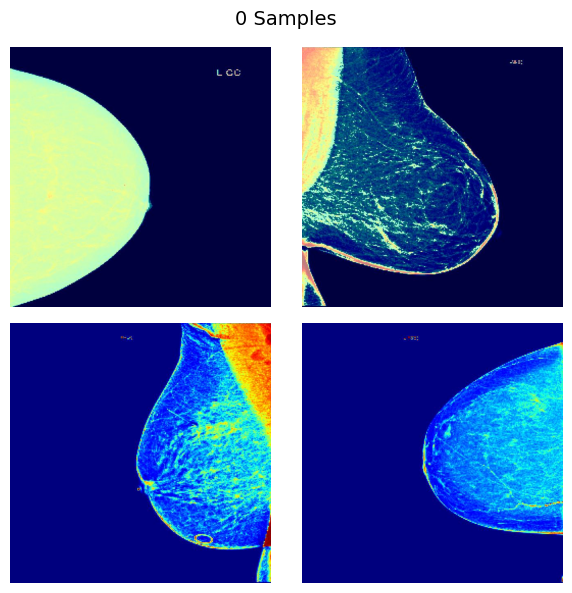

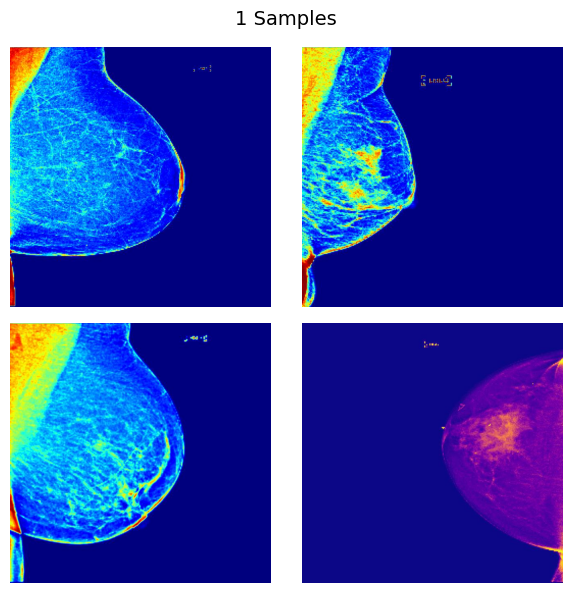

In [4]:
import random

def plot_random_grid(df, target_class, grid_size=2):
    """
    Show a grid of random images from a given class.
    
    Args:
        df (DataFrame): DataFrame with 'class' and 'image_path' columns.
        target_class (str): Class name to filter images.
        grid_size (int): Grid dimension (grid_size x grid_size).
    """
    # Pick random images of the class
    samples = df[df['class'] == target_class].sample(grid_size**2)

    # Create plot grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
    fig.suptitle(f'{target_class} Samples', fontsize=14)

    for i, ax in enumerate(axes.flat):
        img = Image.open(samples.iloc[i]['image_path'])
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples for each class in the dataset
for cls in df['class'].unique():
    plot_random_grid(df, cls)

In [5]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from transformers import AutoImageProcessor, SwinForImageClassification
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2025-05-23 08:00:43.252039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747987243.439190      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747987243.495899      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Define image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),           # Resize images to 224x224
    transforms.ToTensor(),                             # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)   # Normalize RGB channels
])

# transform_train = transforms.Compose([
#     transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Random crop and resize
#     transforms.RandomHorizontalFlip(),            # Random horizontal flip
#     transforms.RandomVerticalFlip(),              # Random vertical flip (useful for medical images)
#     transforms.RandomRotation(degrees=15),        # Small random rotation ±15 degrees
#     transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Slight color adjustments
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
# ])

# Load datasets from folder structure: root/class_name/image.jpg
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

class_names = train_dataset.classes
print("Classes:", class_names)  # Print detected classes

Classes: ['0', '1']


In [7]:
# Create DataLoader for training set
train_loader = DataLoader(
    train_dataset,           # Training data
    batch_size=BATCH_SIZE,   # Batch size
    shuffle=True,            # Shuffle for training
    num_workers=4            # Parallel data loading workers
)

# Create DataLoader for validation set
val_loader = DataLoader(
    val_dataset,             # Validation data
    batch_size=BATCH_SIZE,
    shuffle=False,           # No shuffle during validation
    num_workers=4
)

# Create DataLoader for test set
test_loader = DataLoader(
    test_dataset,            # Test data
    batch_size=BATCH_SIZE,
    shuffle=False,           # No shuffle during testing
    num_workers=4
)

In [ ]:
# Pretrained Swin Tiny
model_name = "microsoft/swin-tiny-patch4-window7-224"
processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # benign and malignant
    ignore_mismatched_sizes=True
).to(device)

In [9]:
from tqdm import tqdm

optimizer = Adam(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

In [10]:
EPOCHS = 10  # Number of training epochs (increase as needed)

for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    running_loss, correct = 0.0, 0  # Initialize loss and correct prediction counters

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)  # Move to device

        optimizer.zero_grad()  # Reset gradients

        outputs = model(pixel_values=images).logits  # ✅ Swin model expects "pixel_values"
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backprop
        optimizer.step()  # Update weights

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()  # Track correct predictions

    train_acc = correct / len(train_dataset)
    print(f"Train Loss: {running_loss:.4f}, Accuracy: {train_acc:.4f}")

    # Validation loop
    model.eval()
    val_correct = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(pixel_values=images).logits  # ✅ again use "pixel_values"
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_dataset)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")


Epoch 1/10: 100%|██████████| 63/63 [00:17<00:00,  3.50it/s]

Train Loss: 43.0565, Accuracy: 0.5535


Validation Loss: 0.6437, Accuracy: 0.6175


Epoch 2/10: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

Train Loss: 37.7849, Accuracy: 0.6775


Validation Loss: 0.6215, Accuracy: 0.6550


Epoch 3/10: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]


Train Loss: 27.3376, Accuracy: 0.8020
Validation Loss: 0.5564, Accuracy: 0.7300


Epoch 4/10: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

Train Loss: 16.5057, Accuracy: 0.8950


Validation Loss: 0.5656, Accuracy: 0.7400


Epoch 5/10: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]

Train Loss: 8.0248, Accuracy: 0.9560


Validation Loss: 0.6298, Accuracy: 0.7475


Epoch 6/10: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

Train Loss: 4.7887, Accuracy: 0.9755


Validation Loss: 0.7586, Accuracy: 0.7800


Epoch 7/10: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]


Train Loss: 2.9334, Accuracy: 0.9905
Validation Loss: 0.7139, Accuracy: 0.7925


Epoch 8/10: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]


Train Loss: 1.4995, Accuracy: 0.9955
Validation Loss: 0.8305, Accuracy: 0.7800


Epoch 9/10: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]

Train Loss: 1.1343, Accuracy: 0.9980


Validation Loss: 0.8545, Accuracy: 0.7925


Epoch 10/10: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]

Train Loss: 2.2913, Accuracy: 0.9845


Validation Loss: 0.7666, Accuracy: 0.7850


In [11]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(pixel_values=imgs).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    return total_loss / len(dataloader), acc
    
    
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Test Loss: 0.8914 | Test Accuracy: 0.7800
